# Problem

We’re building a simple model to forecast nutritional program intake using food insecurity and demographic data. The goal is to understand how population and economic context relate to participation over time.

# Loading Datasets

Here we're loading all 3 datasets and checking their common columns to merge them

In [2609]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, mean_squared_error

In [2610]:
df_intake = pd.read_csv('./data/Nutritional_Programming_West.csv')

/var/folders/lk/dd04v6hx7yxdyxxnq4k1m0n40000gn/T/ipykernel_61241/574217237.py:1: DtypeWarning: Columns (3,4,6,7,8,9,10,11,12,13,14,15) have mixed types. Specify dtype option on import or set low_memory=False.
  df_intake = pd.read_csv('./data/Nutritional_Programming_West.csv')


In [2611]:
df_intake.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 149557 entries, 0 to 149556
Data columns (total 16 columns):
 #   Column                         Non-Null Count   Dtype  
---  ------                         --------------   -----  
 0   Sex                            111144 non-null  object 
 1   Marital Status                 86940 non-null   object 
 2   Year of Birth                  131425 non-null  float64
 3   Birth Province / Country Code  53135 non-null   object 
 4   Home Province Code             95691 non-null   object 
 5   Creation Date                  128297 non-null  object 
 6   Last Modified                  88018 non-null   object 
 7   employmentstatus_DC            21594 non-null   object 
 8   System_CU                      37245 non-null   object 
 9   City_CU                        29656 non-null   object 
 10  Program_CU                     37245 non-null   object 
 11  Citizenship_CU                 37245 non-null   object 
 12  Primary Diagnosis_CU          

In [2612]:
demographic_df = pd.read_csv('./data/Food_insecurity_selected_demographic_characteristics.csv')

In [2613]:
demographic_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 156 entries, 0 to 155
Data columns (total 17 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   REF_DATE                        156 non-null    int64  
 1   GEO                             156 non-null    object 
 2   DGUID                           156 non-null    object 
 3   Demographic characteristics     156 non-null    object 
 4   Household food security status  156 non-null    object 
 5   Statistics                      156 non-null    object 
 6   UOM                             156 non-null    object 
 7   UOM_ID                          156 non-null    int64  
 8   SCALAR_FACTOR                   156 non-null    object 
 9   SCALAR_ID                       156 non-null    int64  
 10  VECTOR                          156 non-null    object 
 11  COORDINATE                      156 non-null    object 
 12  VALUE                           152 

In [2614]:
economic_df = pd.read_csv('./data/Food_insecurity_economic_family_type.csv')

In [2615]:
economic_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 108 entries, 0 to 107
Data columns (total 17 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   REF_DATE                        108 non-null    int64  
 1   GEO                             108 non-null    object 
 2   DGUID                           108 non-null    object 
 3   Economic family type            108 non-null    object 
 4   Household food security status  108 non-null    object 
 5   Statistics                      108 non-null    object 
 6   UOM                             108 non-null    object 
 7   UOM_ID                          108 non-null    int64  
 8   SCALAR_FACTOR                   108 non-null    object 
 9   SCALAR_ID                       108 non-null    int64  
 10  VECTOR                          108 non-null    object 
 11  COORDINATE                      108 non-null    object 
 12  VALUE                           108 

# Data Transformations

Make the datasets compatible so they can be merged later.

## Nutritional Programming

In [2616]:
# Drop rows that are not associated with Nutritional Programming - West
df_intake = df_intake[df_intake['Program_CU'] == 'Nutritional Programming - West']

In [2617]:
# Convert Creation Date to a year
df_intake['Creation Date'] = pd.to_datetime(df_intake['Creation Date'], errors='coerce')
# Convert year into numerical
df_intake['Year'] = df_intake['Creation Date'].dt.year.astype('Int64')


In [2618]:
# Convert year into numerical
df_intake['Year of Birth'] = df_intake['Year of Birth'].astype('Int64')

In [2619]:
# All users come from canada
df_intake['Region'] = 'Canada'

In [2620]:
nutritional_cols_drop = [
    'Creation Date', 'Last Modified'
]
df_intake.drop(columns=[c for c in nutritional_cols_drop if c in df_intake.columns], inplace=True)

In [2621]:
# Replace Nan values
df_intake = df_intake.fillna('Unknown')

In [2622]:
df_intake.info()

<class 'pandas.core.frame.DataFrame'>
Index: 90 entries, 114814 to 114903
Data columns (total 16 columns):
 #   Column                         Non-Null Count  Dtype 
---  ------                         --------------  ----- 
 0   Sex                            90 non-null     object
 1   Marital Status                 90 non-null     object
 2   Year of Birth                  90 non-null     Int64 
 3   Birth Province / Country Code  90 non-null     object
 4   Home Province Code             90 non-null     object
 5   employmentstatus_DC            90 non-null     object
 6   System_CU                      90 non-null     object
 7   City_CU                        90 non-null     object
 8   Program_CU                     90 non-null     object
 9   Citizenship_CU                 90 non-null     object
 10  Primary Diagnosis_CU           90 non-null     object
 11  Program Name_TR                90 non-null     object
 12  ReasonForWithdrawal_CU         90 non-null     object
 13  Cul

### Intake trend

In [2623]:
grouped_sex_citizen = df_intake.groupby(['Citizenship_CU', 'Sex']).size().reset_index(name='Count')
print(grouped_sex_citizen)

     Citizenship_CU              Sex  Count
0  Canadian Citizen    Cisgender Man     37
1  Canadian Citizen  Cisgender Woman     43
2  Landed Immigrant  Cisgender Woman      7
3     None Selected  Cisgender Woman      3


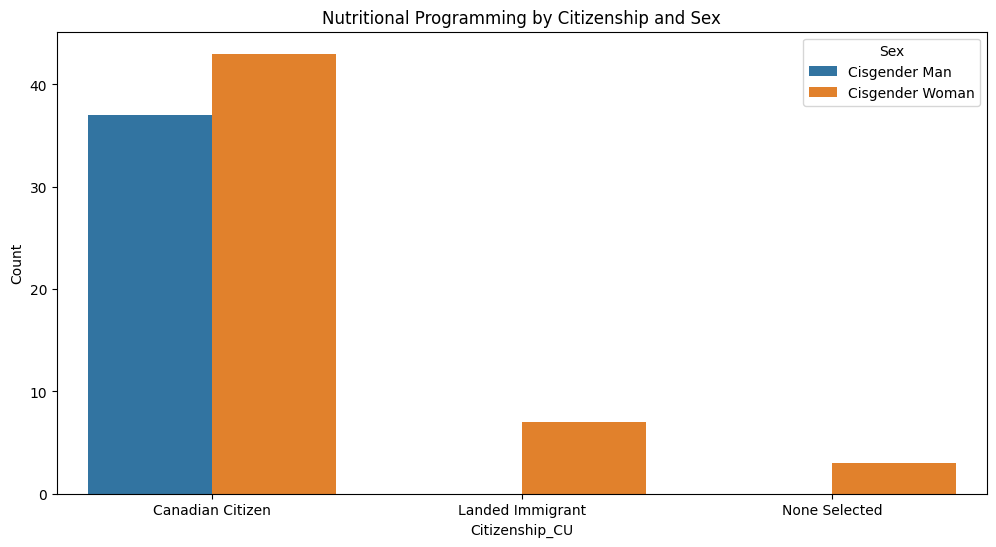

In [2624]:
plt.figure(figsize=(12, 6))
sns.barplot(x='Citizenship_CU', y='Count', hue='Sex', data=grouped_sex_citizen)
plt.title('Nutritional Programming by Citizenship and Sex')
plt.show()

In [2625]:
grouped_sex_marital = df_intake.groupby(['Marital Status', 'Sex']).size().reset_index(name='Count')
print(grouped_sex_marital)

  Marital Status              Sex  Count
0     Common Law  Cisgender Woman      1
1       Divorced    Cisgender Man      4
2       Divorced  Cisgender Woman      1
3        Married    Cisgender Man      2
4  None Selected    Cisgender Man      1
5  None Selected  Cisgender Woman     11
6         Single    Cisgender Man     26
7         Single  Cisgender Woman     24
8        Unknown    Cisgender Man      4
9        Unknown  Cisgender Woman     16


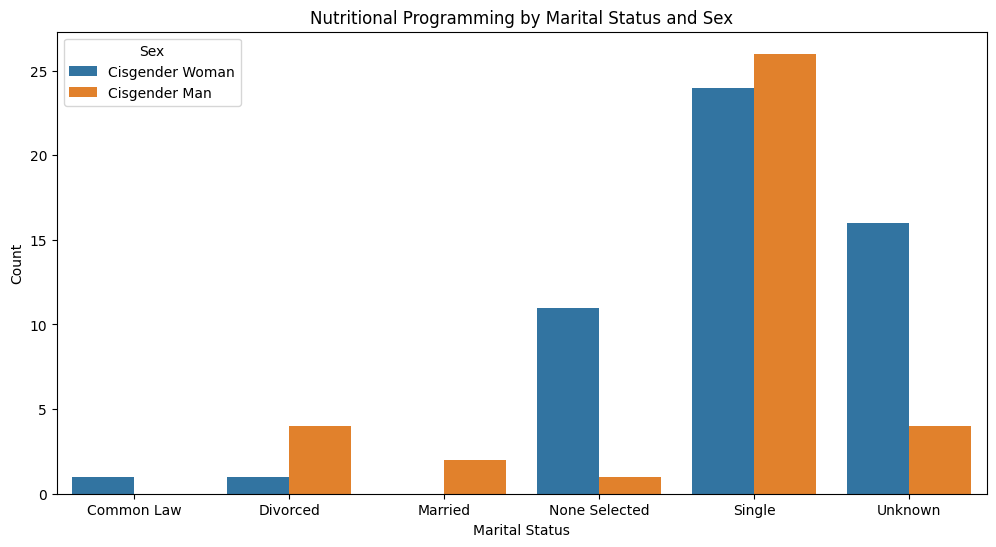

In [2626]:
plt.figure(figsize=(12, 6))
sns.barplot(x='Marital Status', y='Count', hue='Sex', data=grouped_sex_marital)
plt.title('Nutritional Programming by Marital Status and Sex')
plt.show()

In [2627]:
grouped_sex_culture = df_intake.groupby(['Culture_CU', 'Sex']).size().reset_index(name='Count')
print(grouped_sex_culture)

                  Culture_CU              Sex  Count
0   Aboriginal/First Nations  Cisgender Woman      1
1                    African    Cisgender Man      2
2                   Canadian    Cisgender Man     30
3                   Canadian  Cisgender Woman     24
4                  Caribbean  Cisgender Woman      4
5                 East Asian    Cisgender Man      1
6                 East Asian  Cisgender Woman      1
7                   European    Cisgender Man      3
8                   European  Cisgender Woman      7
9   Preferred not to Specify  Cisgender Woman      3
10                   Unknown    Cisgender Man      1
11                   Unknown  Cisgender Woman     13


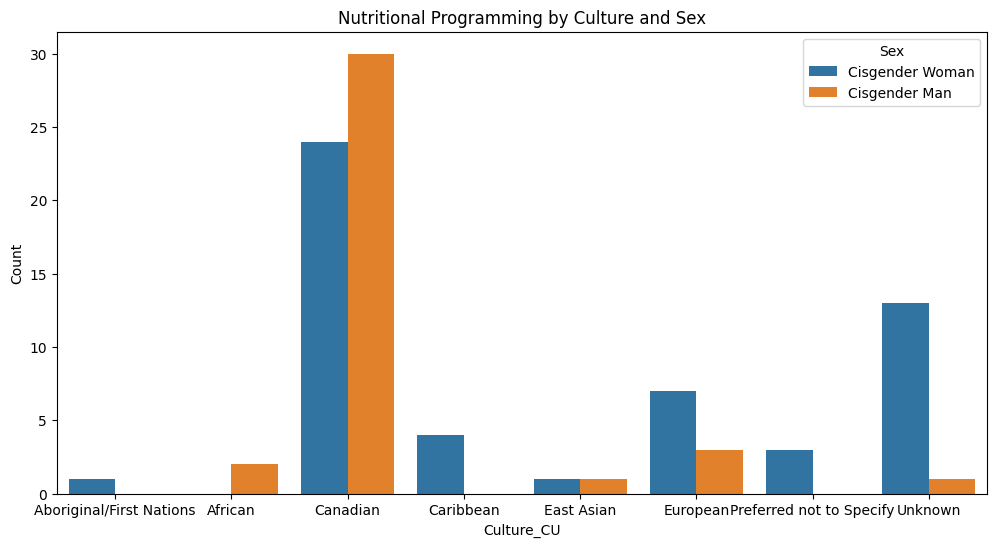

In [2628]:
plt.figure(figsize=(12, 6))
sns.barplot(x='Culture_CU', y='Count', hue='Sex', data=grouped_sex_culture)
plt.title('Nutritional Programming by Culture and Sex')
plt.show()

## Demographic dataset

In [2629]:
demographic_cols_drop = [
    'DGUID', 'VECTOR', 'COORDINATE', 'STATUS', 'SYMBOL',
    'TERMINATED', 'UOM_ID', 'SCALAR_FACTOR', 'SCALAR_ID',
    'Statistics', 'UOM', 'DECIMALS'
]
demographic_df.drop(columns=[c for c in demographic_cols_drop if c in demographic_df.columns], inplace=True)

In [2630]:
rename_demographic = {
    'REF_DATE': 'Year',
    'GEO': 'Region',
    'Demographic characteristics': 'Demographic',
    'Household food security status': 'FoodSecurityStatus',
    'VALUE': 'Value',
}
demographic_df.rename(columns=rename_demographic, inplace=True)

In [2631]:
demographic_df['Year'] = pd.to_numeric(demographic_df['Year'], errors='coerce')
demographic_df['Value'] = pd.to_numeric(demographic_df['Value'], errors='coerce')

### Demographic Trend

In [2632]:
# Pivot table so each demographic is a column
demographic_pivot = demographic_df.pivot_table(
    index='Year',
    columns='Demographic',
    values='Value',
    aggfunc='sum'
).reset_index()

In [2633]:
age_order = [
    'Persons under 18 years',
    'Persons 18 to 24 years',
    'Persons 25 to 34 years',
    'Persons 35 to 44 years',
    'Persons 45 to 54 years',
    'Persons 55 to 64 years',
    'Persons 65 years and over'
]

In [2634]:
# Sort columns: age groups first in order, then any other demographics
demographic_cols = [col for col in age_order if col in demographic_pivot.columns] + \
                   [col for col in demographic_pivot.columns if col not in age_order + ['Year']]

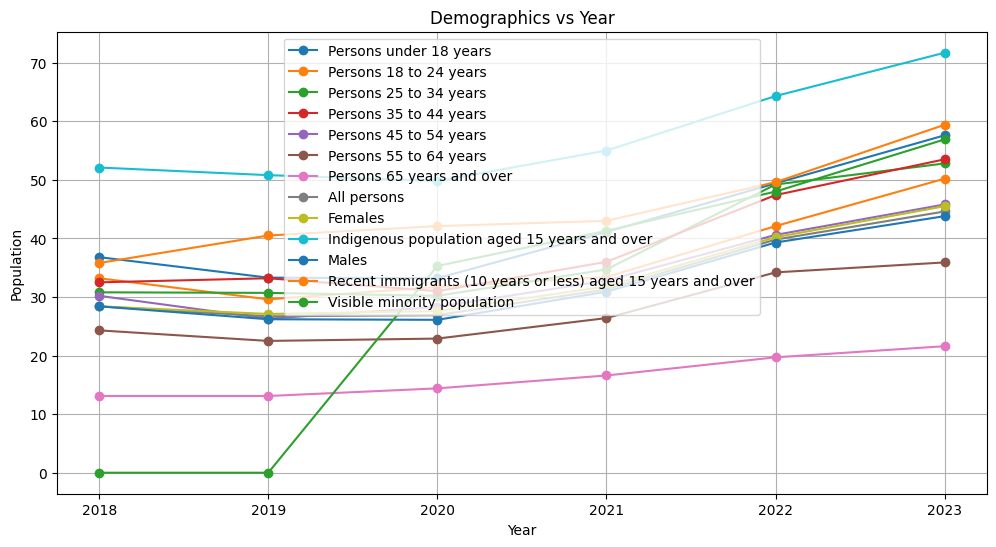

In [2635]:
plt.figure(figsize=(12,6))
for col in demographic_cols:
    plt.plot(demographic_pivot['Year'], demographic_pivot[col], marker='o', label=col)

plt.xlabel('Year')
plt.ylabel('Population')
plt.title('Demographics vs Year')
plt.legend()
plt.grid(True)
plt.show()

## Economic dataset

In [2636]:
economic_cols_drop = [
    'DGUID', 'VECTOR', 'COORDINATE', 'STATUS', 'SYMBOL',
    'TERMINATED', 'UOM_ID', 'SCALAR_FACTOR', 'SCALAR_ID',
    'Statistics', 'UOM', 'DECIMALS'
]
economic_df.drop(columns=[c for c in economic_cols_drop if c in economic_df.columns], inplace=True)


In [2637]:
rename_economic = {
    'REF_DATE': 'Year',
    'GEO': 'Region',
    'Economic family type': 'EconomicType',
    'Household food security status': 'FoodSecurityStatus',
    'VALUE': 'Value',
}
economic_df.rename(columns=rename_economic, inplace=True)

In [2638]:
economic_df['Year'] = pd.to_numeric(economic_df['Year'], errors='coerce')
economic_df['Value'] = pd.to_numeric(economic_df['Value'], errors='coerce')

In [2639]:
economic_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 108 entries, 0 to 107
Data columns (total 5 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   Year                108 non-null    int64  
 1   Region              108 non-null    object 
 2   EconomicType        108 non-null    object 
 3   FoodSecurityStatus  108 non-null    object 
 4   Value               108 non-null    float64
dtypes: float64(1), int64(1), object(3)
memory usage: 4.3+ KB


### Economic Trend

In [2640]:
# Pivot table so each demographic is a column
economic_pivot = economic_df.pivot_table(
    index='Year',
    columns='EconomicType',
    values='Value',
    aggfunc='sum'
).reset_index()

In [2641]:
economic_order = [
    'EconomicType_Non-seniors not in an economic family',
    'EconomicType_Persons in couple families with children',
    'EconomicType_Persons in economic families',
    'EconomicType_Persons in lone-parent families',
    'EconomicType_Persons in non-senior families',
    'EconomicType_Persons in senior families',
    'EconomicType_Persons not in an economic family',
    'EconomicType_Seniors not in an economic family'
]

In [2642]:
# Sort columns: age groups first in order, then any other economics
economic_cols = [col for col in economic_order if col in economic_pivot.columns] + \
                [col for col in economic_pivot.columns if col not in economic_order + ['Year']]

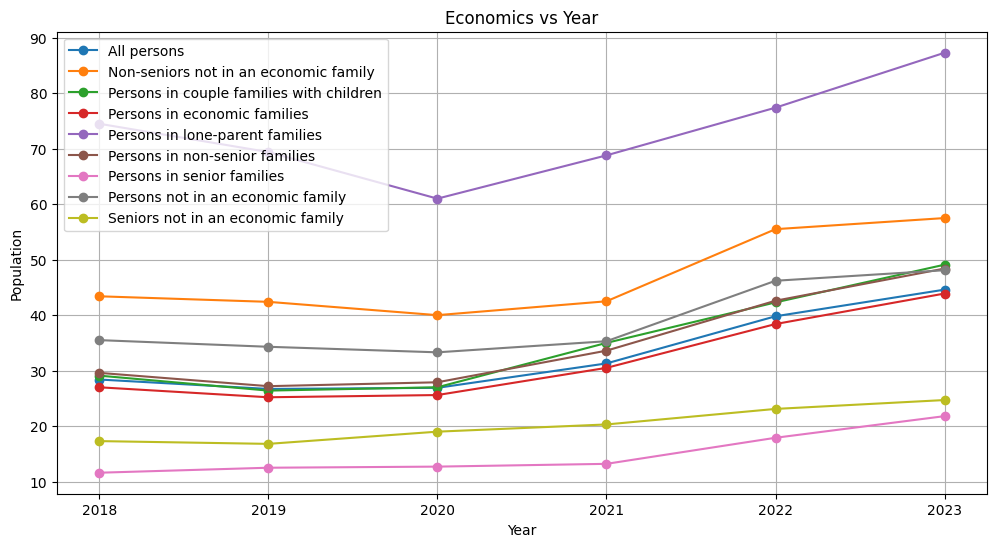

In [2643]:
plt.figure(figsize=(12,6))
for col in economic_cols:
    plt.plot(economic_pivot['Year'], economic_pivot[col], marker='o', label=col)

plt.xlabel('Year')
plt.ylabel('Population')
plt.title('Economics vs Year')
plt.legend()
plt.grid(True)
plt.show()

In [2644]:
# Pivot table so each demographic is a column
insecurity_pivot = economic_df.pivot_table(
    index='Year',
    columns='FoodSecurityStatus',
    values='Value',
    aggfunc='sum'
).reset_index()

In [2645]:
insecurity_order = [
    'FoodSecurityStatus_Food insecure',
    'FoodSecurityStatus_Food insecure, moderate or severe'
]

In [2646]:
# Sort columns: age groups first in order, then any other economics
insecurity_cols = [col for col in insecurity_order if col in insecurity_pivot.columns] + \
                  [col for col in insecurity_pivot.columns if col not in insecurity_order + ['Year']]

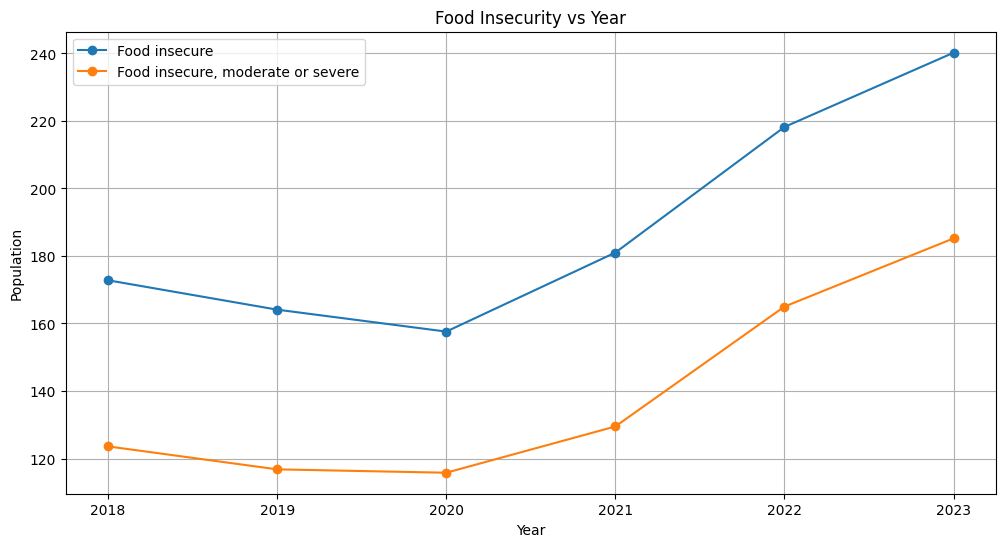

In [2647]:
plt.figure(figsize=(12,6))
for col in insecurity_cols:
    plt.plot(insecurity_pivot['Year'], insecurity_pivot[col], marker='o', label=col)

plt.xlabel('Year')
plt.ylabel('Population')
plt.title('Food Insecurity vs Year')
plt.legend()
plt.grid(True)
plt.show()

# Merging datasets

In [2648]:
intake_agg = (
    df_intake.groupby(['Year','Region'])
    .size()
    .reset_index(name='Intake')
)

# Merge economic data
df_all = intake_agg.merge(
    economic_df, 
    on=['Year','Region'], 
    how='left'
)

# Merge demographic data
df_all = df_all.merge(
    demographic_df, 
    on=['Year','Region'], 
    how='left'
)

In [2649]:
# Replace Nan values
df_all['Value_x'].fillna(df_all['Value_x'].median(), inplace=True)
df_all['Value_y'].fillna(df_all['Value_y'].median(), inplace=True)

df_all = df_all.fillna('Unknown')

/var/folders/lk/dd04v6hx7yxdyxxnq4k1m0n40000gn/T/ipykernel_61241/101933140.py:2: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df_all['Value_x'].fillna(df_all['Value_x'].median(), inplace=True)
/var/folders/lk/dd04v6hx7yxdyxxnq4k1m0n40000gn/T/ipykernel_61241/101933140.py:3: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are set

In [2650]:
# Transform values into numeric
df_all['Value_x'] = pd.to_numeric(df_all['Value_x'], errors='coerce')
df_all['Value_y'] = pd.to_numeric(df_all['Value_y'], errors='coerce')

In [2651]:
# One-Hot Encode categorical columns
df_all = pd.get_dummies(
    df_all, 
    columns=['EconomicType', 'Demographic', 'FoodSecurityStatus_x', 'FoodSecurityStatus_y'], 
    drop_first=True
)

In [2652]:
print(df_all.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1875 entries, 0 to 1874
Data columns (total 31 columns):
 #   Column                                                                   Non-Null Count  Dtype  
---  ------                                                                   --------------  -----  
 0   Year                                                                     1875 non-null   Int64  
 1   Region                                                                   1875 non-null   object 
 2   Intake                                                                   1875 non-null   int64  
 3   Value_x                                                                  1875 non-null   float64
 4   Value_y                                                                  1875 non-null   float64
 5   EconomicType_Non-seniors not in an economic family                       1875 non-null   bool   
 6   EconomicType_Persons in couple families with children                   

In [2653]:
print(df_all.head())

   Year  Region  Intake  Value_x  Value_y  \
0  2014  Canada      13     15.1    15.45   
1  2015  Canada      23     15.1    15.45   
2  2016  Canada      25     15.1    15.45   
3  2018  Canada      14     16.8    16.80   
4  2018  Canada      14     16.8    11.60   

   EconomicType_Non-seniors not in an economic family  \
0                                              False    
1                                              False    
2                                              False    
3                                              False    
4                                              False    

   EconomicType_Persons in couple families with children  \
0                                              False       
1                                              False       
2                                              False       
3                                              False       
4                                              False       

   EconomicType_Persons i

# Prepare for modeling

In [2654]:
# Sort by year and region
df_all = df_all.sort_values(['Region','Year'])

In [2655]:
# 1-year lag of Intake
df_all['Intake_lag1'] = df_all.groupby('Region')['Intake'].shift(1)

# Handle missing values
df_all['Intake_lag1'].fillna(method='bfill', inplace=True)

/var/folders/lk/dd04v6hx7yxdyxxnq4k1m0n40000gn/T/ipykernel_61241/1574314876.py:5: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df_all['Intake_lag1'].fillna(method='bfill', inplace=True)
/var/folders/lk/dd04v6hx7yxdyxxnq4k1m0n40000gn/T/ipykernel_61241/1574314876.py:5: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df_all['Intake_lag1'].fillna(method='bfill', inplace=True)


In [2656]:
train = df_all[df_all['Year'] <= 2019]
test  = df_all[df_all['Year'] >  2019]

In [2657]:
feature_cols = ['Year', 'Intake_lag1']
X_train, y_train = train[feature_cols], train['Intake']
X_test, y_test = test[feature_cols], test['Intake']

In [2658]:
scaler = StandardScaler()

In [2659]:
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled  = scaler.transform(X_test)

# Building a simple model

In [2660]:
model = LinearRegression()
model.fit(X_train_scaled, y_train)

,fit_intercept,True
,copy_X,True
,tol,1e-06
,n_jobs,None
,positive,False


In [2661]:
y_pred = model.predict(X_test_scaled)

mae = mean_absolute_error(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))

In [2662]:
print(f'MAE: {mae:.2f}')
print(f'RMSE: {rmse:.2f}')

MAE: 3.07
RMSE: 3.31


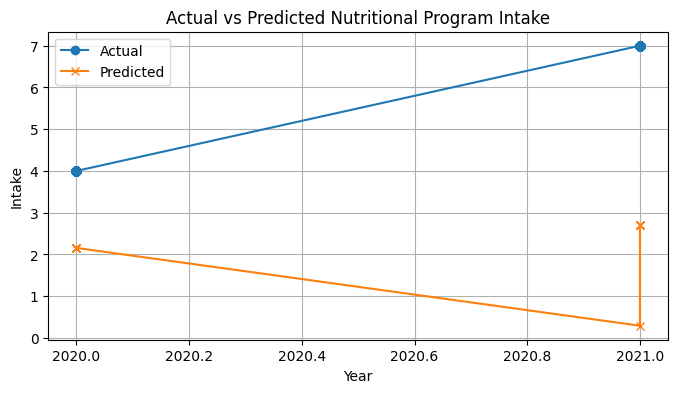

In [2663]:
plt.figure(figsize=(8,4))
plt.plot(test['Year'], y_test, label='Actual', marker='o')
plt.plot(test['Year'], y_pred, label='Predicted', marker='x')
plt.title('Actual vs Predicted Nutritional Program Intake')
plt.xlabel('Year')
plt.ylabel('Intake')
plt.legend()
plt.grid(True)
plt.show()